In [466]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import datetime
from dataclasses import dataclass, field

from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline

from sktime.transformations.panel.rocket import Rocket

from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

from sktime import datatypes


In [467]:
def gen_labellist(columns):
    global df
    label_list =[]
    for value, group_df in df.groupby(level='id'):
        inner = []
        for col in columns.split(','):
            id_series = group_df[col]
            first_element = id_series.iloc[0]
            inner.append(first_element)
        label_list.append(inner)
    label_list = np.array(label_list)
    for col in columns.split(','):
        df = df.drop(col, axis=1)
    return label_list

def gen_labellist_test(columns):
    global test
    label_list =[]
    for value, group_df in test.groupby(level='id'):
        inner = []
        for col in columns.split(','):
            id_series = group_df[col]
            first_element = id_series.iloc[0]
            inner.append(first_element)
        label_list.append(inner)
    label_list = np.array(label_list)
    for col in columns.split(','):
        test = test.drop(col, axis=1)
    return label_list

def dataframe_rocket(df):
    nested_dict = {}
    for time, group_df in df.groupby(level='t_sec'):
        enzyme_dict = {}
        for column_name in df.columns:
            xs = df.xs(time, level='t_sec')[column_name]
            enzyme_dict[column_name] = xs
        nested_dict[time] = enzyme_dict
    dataframe = pd.DataFrame(nested_dict)
    dataframe = dataframe.transpose()
    return dataframe

def gen_3d_nparray(df):
    d3_array = []
    for value, group_df in df.groupby(level='id'):
        inner_array = []
        for col in df.columns:
            inner = np.array(group_df[col])
            inner_array.append(inner)
        inner_nparray = np.array(inner_array)
        d3_array.append(inner_nparray)
    d3_nparray = np.array(d3_array)
    return d3_nparray

In [468]:
start_time = datetime.datetime.now()

In [469]:
name = 'mapk361_n25_inh0_nonoise'
df = pd.read_csv('dataset_mapk361_n25_inh0_nonoise_h25_train.csv', sep=',',
                 index_col=['id', 't_sec'])
status_array = gen_labellist('desc')
df = df.drop('status', axis=1)
df = df.drop('inhibition', axis=1)
df = df.drop('inh_strength', axis=1)
new_level2 = pd.RangeIndex(start=0, stop=len(df), step=1)
df.index = df.index.set_levels(new_level2, level='t_sec')

/var/folders/b4/pcdvhyhx15vb8w5sq0k6wz980000gn/T/ipykernel_11730/1496083311.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset_mapk361_n25_inh0_nonoise_h25_train.csv', sep=',',


In [470]:
test = pd.read_csv('dataset_mapk361_n25_inh0_nonoise_h25_test.csv', sep=',',
                 index_col=['id', 't_sec'])
test.index = test.index.set_levels(new_level2, level='t_sec')
status_array_test = gen_labellist_test('desc')
test = test.drop('status', axis=1)
test = test.drop('inhibition', axis=1)
test = test.drop('inh_strength', axis=1)

/var/folders/b4/pcdvhyhx15vb8w5sq0k6wz980000gn/T/ipykernel_11730/910061132.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('dataset_mapk361_n25_inh0_nonoise_h25_test.csv', sep=',',


In [471]:
rocket_array = gen_3d_nparray(df)

In [472]:
rocket_array = rocket_array.astype(float)

In [473]:
rocket_array.dtype

dtype('float64')

In [474]:
data = (df, status_array)

In [475]:
# X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = df
y_train = status_array
X_test = test
y_test = status_array_test

In [476]:
datatypes.check_raise(X_train, 'pd-multiindex')

True

In [477]:
rocket = Rocket(n_jobs=-1)
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

In [478]:
X_test_transform = rocket.transform(X_test)

In [479]:
X_train_transform.shape

(726, 20000)

In [480]:
X_train

MKKK        MKKK_P         MKK         MKK_P        MKK_PP  \
id  t_sec                                                                     
0   0      103.107439 -5.534079e+00  300.971661  8.382192e+00 -3.955745e+00   
    1       86.618931  3.807860e+00  296.860870  2.454985e+00  2.267677e+00   
    2       87.934834  1.877844e+01  293.988210  8.375027e-01 -4.529206e+00   
    3       76.465968  1.996279e+01  298.606369  1.385218e+00  9.540002e+00   
    4       57.787583  4.475158e+01  293.686166  6.305139e+00 -7.632093e+00   
...               ...           ...         ...           ...           ...   
725 356     97.000000  5.486817e-09  294.000000 -6.830693e-11  1.788019e-18   
    357     97.000000 -2.310042e-08  294.000000  2.801168e-10  1.816441e-18   
    358     97.000000  1.304180e-08  294.000000 -1.603860e-10  2.040337e-18   
    359     97.000000 -1.331345e-08  294.000000  1.608075e-10  2.202296e-18   
    360     97.000000 -6.637038e-09  294.000000  7.940939e-11  2.082818e-18   

                 MAPK    MAPK_P   MAPK_PP      Signal       Signal_A  \
id  t_sec                                                              
0   0      296.300180 -0.864342 -2.141319    0.055363   1.975688e+02   
    1      304.327314  3.194868  5.944832   23.195293   1.985338e+02   
    2      298.460106  4.272817  5.158037   15.516339   1.650910e+02   
    3      303.975740  6.518074  0.450742   36.327592   1.659424e+02   
    4      299.052033 -4.953441  3.053356   40.711017   1.601340e+02   
...               ...       ...       ...         ...            ...   
725 356    294.993357  0.006599  0.000044  200.000000  5.335433e-183   
    357    294.994324  0.005639  0.000037  200.000000  1.528651e-183   
    358    294.995150  0.004819  0.000032  200.000000  4.379654e-184   
    359    294.995855  0.004117  0.000027  200.000000  1.254814e-184   
    360    294.996458  0.003518  0.000023  200.000000  3.595133e-185   

                  RAS         RAS_A  
id  t_sec                            
0   0       99.955147 -4.427972e+00  
    1       24.044471  9.316512e+01  
    2       -4.247695  1.070612e+02  
    3        7.011335  9.597617e+01  
    4        2.595599  8.880456e+01  
...               ...           ...  
725 356    101.000000 -4.776267e-07  
    357    100.999998  2.009646e-06  
    358    101.000001 -1.134978e-06  
    359    100.999999  1.158086e-06  
    360    100.999999  5.772015e-07  

[262086 rows x 12 columns]

In [481]:
weight = {}
classes = np.unique(y_train)
for i in classes:
    if i == '-':
        weight[i] = 1
    else:
        weight[i] = 1
weight

{'-': 1,
 'mapk': 1,
 'mapk, mkk, mkkk': 1,
 'mkk': 1,
 'mkk_pp': 1,
 'mkkk': 1,
 'mkkk_p': 1,
 'mkp_mapk': 1,
 'mkp_mapk, mkp_mkk, mkp_mkkk': 1,
 'mkp_mkk': 1,
 'mkp_mkkk': 1,
 'ras': 1,
 'ras_active': 1,
 'signal_active': 1}

In [482]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, y_train)

/Users/slw/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:1178: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [483]:
y_pred = classifier.predict(X_test_transform)

In [484]:
end_time = datetime.datetime.now()

In [485]:
classifier.score(X_test_transform, y_test)

0.9545454545454546

In [486]:
cm = confusion_matrix(y_test, y_pred)

In [487]:
cm

array([[ 26,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  2,  23,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   1,  22,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  2,   0,   0,  23,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  2,   0,   0,   0,  73,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   1,   0,   0,  24,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  3,   0,   0,   0,   0,   0,  72,   0,   0,   0,   0,   0,   0,
          0],
       [  2,   0,   0,   0,   0,   0,   0,  98,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  21,   3,   1,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0,
          0],
       [  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,  98,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0, 

In [488]:
print(cm)

[[ 26   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2  23   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1  22   0   0   2   0   0   0   0   0   0   0   0]
 [  2   0   0  23   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0  73   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0  24   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0  72   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0  98   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  21   3   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0 100   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0  98   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  25   0   0]
 [  6   0   0   0   0   0   6   0   0   0   0   0  63   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  25]]


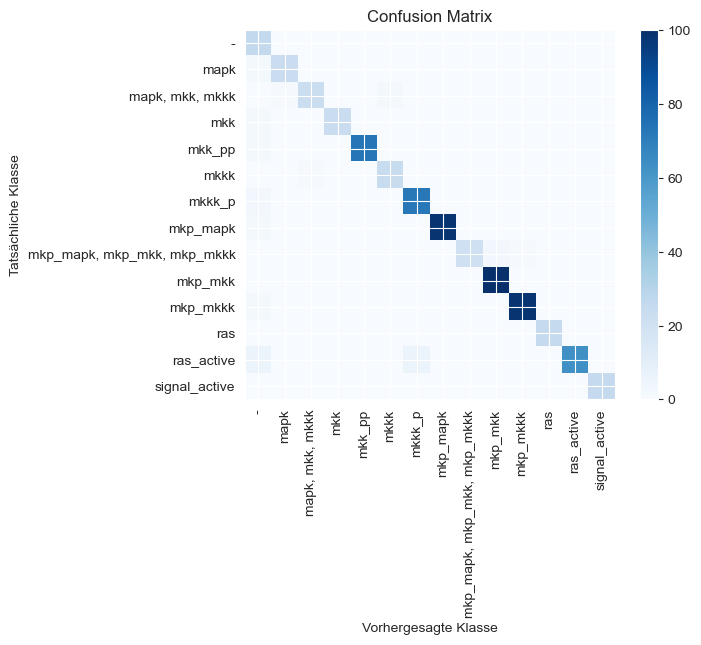

In [489]:
classes = np.unique(y_train)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xticks(rotation='vertical')

plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')
plt.show()

In [490]:
pscore = precision_score(y_test, y_pred, average=None)

In [491]:
for i , value in enumerate(pscore):
    print(f'{classifier.classes_[i]} = {np.round(value, 2)}')

- = 0.58
mapk = 0.96
mapk, mkk, mkkk = 0.96
mkk = 1.0
mkk_pp = 1.0
mkkk = 0.92
mkkk_p = 0.92
mkp_mapk = 1.0
mkp_mapk, mkp_mkk, mkp_mkkk = 1.0
mkp_mkk = 0.97
mkp_mkkk = 0.99
ras = 1.0
ras_active = 1.0
signal_active = 1.0


In [492]:
classifier.classes_

array(['-', 'mapk', 'mapk, mkk, mkkk', 'mkk', 'mkk_pp', 'mkkk', 'mkkk_p',
       'mkp_mapk', 'mkp_mapk, mkp_mkk, mkp_mkkk', 'mkp_mkk', 'mkp_mkkk',
       'ras', 'ras_active', 'signal_active'], dtype='<U27')

In [493]:
X_test_transform

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.337950,4.234829,0.155125,11.314876,0.429363,10.430215,0.550725,6.707301,0.529086,2.293153,...,0.193717,32.325291,0.655949,13.980444,0.396122,12.966604,0.494662,18.438555,0.075188,12.340940
1,0.235457,2.874131,0.047091,11.623925,0.282548,8.742832,0.724638,6.389279,0.720222,1.841362,...,0.099476,29.783497,0.749196,11.882515,0.335180,15.633795,0.640569,19.299377,0.037594,6.347503
2,0.268698,3.168123,0.047091,11.609302,0.290859,9.268821,0.692754,6.381925,0.711911,1.862365,...,0.115183,31.114952,0.720257,12.360096,0.321330,15.296803,0.615658,19.147697,0.045113,8.190915
3,0.149584,2.205249,0.047091,11.639036,0.263158,8.942341,0.800000,6.900367,0.745152,1.907695,...,0.062827,21.892408,0.826367,11.702593,0.554017,16.938124,0.804270,16.534901,0.000000,-0.547494
4,0.116343,5.016124,0.047091,11.638070,0.210526,10.667192,0.846377,8.130082,0.786704,2.523958,...,0.057592,17.516121,0.858521,17.198305,0.667590,12.809737,0.839858,1.788620,0.007519,0.779194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,0.274238,3.283058,0.047091,11.631050,0.315789,10.025746,0.742029,5.768931,0.678670,1.996538,...,0.230366,32.729969,0.700965,13.166156,0.468144,12.461921,0.473310,10.625082,0.075188,12.492042
722,0.271468,3.279301,0.047091,11.631055,0.315789,10.032728,0.742029,5.776064,0.678670,1.993659,...,0.225131,32.823326,0.697749,13.127862,0.465374,12.491852,0.473310,10.771534,0.075188,12.442073
723,0.271468,3.293310,0.047091,11.616455,0.318560,9.984424,0.753623,5.859221,0.675900,2.008878,...,0.240838,32.340828,0.697749,13.324992,0.479224,12.354874,0.462633,10.093339,0.075188,12.678279
724,0.271468,3.267444,0.047091,11.623701,0.318560,10.063338,0.750725,5.825995,0.678670,1.996924,...,0.230366,32.710701,0.697749,13.067831,0.470914,12.493147,0.462633,10.767132,0.075188,12.571197


In [494]:
X_test

MKKK        MKKK_P         MKK         MKK_P        MKK_PP  \
id  t_sec                                                                    
0   0      95.603885 -2.105099e+00  285.140006  9.767289e+00 -4.084033e+00   
    1      99.007609  1.267541e+00  298.968537 -3.403695e+00  3.977352e+00   
    2      80.992103  1.281627e+01  297.301771  6.420255e+00 -1.105600e-02   
    3      72.625353  2.013624e+01  292.425660 -1.717058e+00 -9.974075e-01   
    4      58.462592  3.624270e+01  280.828871  9.003610e+00  1.559270e+00   
...              ...           ...         ...           ...           ...   
725 356    98.000000  4.664053e-09  292.000000 -5.825041e-11  1.749972e-18   
    357    98.000000 -2.425207e-08  292.000000  2.940665e-10  1.786507e-18   
    358    98.000000  1.218438e-08  292.000000 -1.498731e-10  2.013022e-18   
    359    98.000000 -1.425452e-08  292.000000  1.722335e-10  2.177599e-18   
    360    98.000000 -6.895127e-09  292.000000  8.254165e-11  2.065592e-18   

                 MAPK    MAPK_P    MAPK_PP      Signal       Signal_A  \
id  t_sec                                                               
0   0      309.739594  1.279162 -15.617732   -1.506497   1.979898e+02   
    1      293.386610 -0.705616  -0.247959   18.082854   1.952114e+02   
    2      301.227605 -0.376609   2.420112   19.041271   1.750555e+02   
    3      301.999966  2.429506   5.385054   27.510627   1.599738e+02   
    4      298.836218  7.906035   0.698516   38.368633   1.573296e+02   
...               ...       ...        ...         ...            ...   
725 356    292.994893  0.005073   0.000034  200.000000  5.335427e-183   
    357    292.995636  0.004335   0.000029  200.000000  1.528649e-183   
    358    292.996271  0.003704   0.000025  200.000000  4.379649e-184   
    359    292.996814  0.003165   0.000021  200.000000  1.254813e-184   
    360    292.997277  0.002705   0.000018  200.000000  3.595128e-185   

                  RAS         RAS_A  
id  t_sec                            
0   0      102.663060 -1.380066e+01  
    1       23.106448  7.682466e+01  
    2       -9.641640  9.649182e+01  
    3       -5.048185  1.066046e+02  
    4       10.712576  8.954980e+01  
...               ...           ...  
725 356    100.000000 -4.056501e-07  
    357     99.999998  2.107837e-06  
    358    100.000001 -1.059362e-06  
    359     99.999999  1.238785e-06  
    360     99.999999  5.990874e-07  

[262086 rows x 12 columns]

In [495]:
solutiondf = pd.Series()
solutiondf['name'] = name
for i , value in enumerate(precision_score(y_test, y_pred, average=None)):
    print(f'{classifier.classes_[i]} = {np.round(value, 3)}')
    solutiondf[classifier.classes_[i]] = np.round(value, 3)
solutiondf['acc'] = np.round(classifier.score(X_test_transform, y_test), 3)
runtime = end_time - start_time
minutes_difference = runtime.total_seconds() / 60
solutiondf['time'] = np.round(minutes_difference, 3)
solutiondf['cm'] = cm
solutiondf['type'] = 'rocket'
solutiondf['y'] = y_pred
solutiondf = pd.DataFrame([solutiondf])
output_folder = os.path.join('solutions', 'rocket')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
path = os.path.join(output_folder, f'{name}.csv')
# solutiondf.to_csv(path, mode='w', header=True)

- = 0.578
mapk = 0.958
mapk, mkk, mkkk = 0.957
mkk = 1.0
mkk_pp = 1.0
mkkk = 0.923
mkkk_p = 0.923
mkp_mapk = 1.0
mkp_mapk, mkp_mkk, mkp_mkkk = 1.0
mkp_mkk = 0.971
mkp_mkkk = 0.99
ras = 1.0
ras_active = 1.0
signal_active = 1.0


/var/folders/b4/pcdvhyhx15vb8w5sq0k6wz980000gn/T/ipykernel_11730/2299570533.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  solutiondf = pd.Series()


In [496]:
print(solutiondf)

                       name      -   mapk  mapk, mkk, mkkk  mkk  mkk_pp  \
0  mapk361_n25_inh0_nonoise  0.578  0.958            0.957  1.0     1.0   

    mkkk  mkkk_p  mkp_mapk  mkp_mapk, mkp_mkk, mkp_mkkk  mkp_mkk  mkp_mkkk  \
0  0.923   0.923       1.0                          1.0    0.971      0.99   

   ras  ras_active  signal_active    acc   time  \
0  1.0         1.0            1.0  0.955  2.432   

                                                  cm    type  \
0  [[26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...  rocket   

                                                   y  
0  [-, mapk, mkk, mkkk, mapk, mkk, mkkk, mapk, mk...  
